Data are stored as shown Below:

 * ColeegData/datasets
 * ColeegData/results
 * ColeegData/content   (for local runtime)

To connect to a local runtime on your machine:
* Press the arrow beside **Connect** and select **"Connect to a local runtime"**.
* Inside Coleeg folder located in your local machine home folder, run the command (bash Colab_Local)
* Copy the generated url then paste it in Colab and press connect.


# Initialization

In [ ]:
coleeg_folder="Coleeg3.1"
coleeg_data_folder="ColeegData"
result_folder="results"  #default results subfolder, change it for another if you wish

# installing packages with the version last used in Colab hosted run time
!pip install  mne==1.7.0 --force-reinstall
!pip install  tensorflow==2.15.0 --force-reinstall
!pip install  numpy==1.25.2 --force-reinstall
!pip install  keras==2.15.0 --force-reinstall

# !pip install -q tensorflow-addons


import numpy as np
import sys
import os
from importlib import reload


# detecting if Colab or local runtime is used
if 'google.colab' in sys.modules:  # Colab runtime
  from google.colab import drive
  # mounting Google drive
  drive.mount('/gdrive')
  root_folder=f'/gdrive/MyDrive'
else: # local runtime
  root_folder= f'{os.path.expanduser("~")}'

# Importing coleeg functions
sys.path.append(f'{root_folder}/{coleeg_folder}/code/')
from coleeg import *
reload(sys.modules['coleeg'])
from coleeg import *

# disable line breaking when printing array objects
np.set_printoptions(linewidth=np.nan)
def set_coleeg_parameters():
  set_data_folder(f'{root_folder}/{coleeg_data_folder}')
  #====================== options =================================
  set_result_folder(result_folder)
  # available metrics for validation: 'val_loss', 'val_accuracy', 'val_cohen_kappa', 'val_specificity', 'val_sensitivity'
  # available metrics for training:  'loss', 'accuracy', 'cohen_kappa', 'specificity', 'sensitivity'
  set_metrics(['val_accuracy'])
  set_metrics(['val_loss', 'val_accuracy', 'val_cohen_kappa', 'val_specificity', 'val_sensitivity'])
  set_time_zone('Asia/Amman')
  #=================================================================

set_coleeg_parameters()

# # use the following code to print all available time zone
# import pytz
# for timeZone in pytz.all_timezones: print(timeZone)

# Show info about coleeg

In [ ]:
coleeg_version()

3.1


In [ ]:
coleeg_info()

# Select dataset

In [2]:
#====name================ Options =======================
dataset = 'bcicomptIV2a' # Select one of 'physionet', 'ttk', 'bcicomptIV2a'
#=====================================================


# Obtaining data files.

In [3]:
start_time = time.time()
unzip_dataset(dataset=dataset)
print(f'Time = {timedelta(seconds=round(time.time() - start_time))}')


Data already exists.
Time = 0:00:00


# Loading data

In [5]:
#====================== Options  ==============================
resample_freq = None # resample frequency in Hz (Set to None to deactivate)
resample_freq = 100 # resample frequency in Hz (Set to None to deactivate)
Bands = None
# Bands = [(0.5, 8.0), (8.0, 13.0), (13.0, 40.0)] # Uncomment this line to divide signals into bands

notch_freqs = None # frequency (or list of frequencies) to which a notch filter is applied, example notch_freqs = 50
tmin = 0.0
tmax = 2.0

# select tasks for Physionet dataset
# Tasks = np.array([[3,7,11],[5,9,13]]) # Real movement
Tasks=np.array([[4,8,12],[6,10,14]]) # Uncommnet this line for imagined movement
#=============================================================================================
# set sample frequency
Sample_Freqs = {'physionet':160, 'ttk':500, 'bcicomptIV2a':250, 'chbmit':256}
if resample_freq is not None:
  Fs = resample_freq
else:
  Fs = Sample_Freqs[dataset]

# Delete variables
data_input,data_x, data_x2D, data_y, data_yc,  train_x, train_x2D, train_y, train_yc, test_x, test_x2D, test_y, test_yc = 0,0,0,0,0,0,0,0,0,0,0,0,0
del data_input, data_x, data_x2D, data_y, data_yc,  train_x, train_x2D, train_y, train_yc, test_x, test_x2D, test_y, test_yc

start_time = time.time()

# loading data
if dataset == 'bcicomptIV2a':
  import warnings
  warnings.filterwarnings("ignore", category=DeprecationWarning) # disable annoying error messages from python
  data_x, data_y, data_index = get_data_bcicomptIV2a(resample_freq=resample_freq, Bands=Bands, tmin=tmin, tmax=(tmax-1/Fs), Baseline=None)
elif dataset == 'physionet':
  data_x, data_y, data_index = get_data_physionet(resample_freq=resample_freq, Tasks=Tasks, Bands=Bands,  tmin=tmin, tmax=(tmax-1/Fs), Baseline=None, notch_freqs=notch_freqs)
  #data_x, data_y, data_index = get_data_physionet(Subjects=np.arange(1,101),data_path=data_path, resample_freq=resample_freq, Tasks=Tasks, Bands=Bands,  tmin=tmin, tmax=(tmax-1/Fs), Baseline=None, notch_freqs=notch_freqs)
elif dataset == 'ttk':
  data_x, data_y, data_index = get_data_ttk(resample_freq=resample_freq, Bands=Bands, tmin=tmin, tmax=(tmax-1/Fs), Baseline=None)
else:
  print('Wrong dataset')

print(f'\nTime = {timedelta(seconds=round(time.time() - start_time))}')

# normalizing data (mean => 0, standard deviation => 1)
normalize(data_x)

# balancing data (for each subject, the number of each class is equal)
data_x, data_y, data_index = balance(data_x, data_y, data_index)



No subject excluded
Loading subject 18/18
Time = 0:01:06
Normalizing data done.
Balancing data done.


# Reload coleeg (Run when coleeg.py is changed)

In [ ]:
# run it when coleeg.py is changed
reload(sys.modules['coleeg'])
from coleeg import *
set_coleeg_parameters()

# Model Evaluation

In [ ]:
#====================== Options ===========================
# model_list: dictionary for models and list of epochs for training, modify according to your configuration
# Select one or more of the following models: 'Basic','CNN1D', 'EEGNet', 'ShallowConvNet', 'DeepConvNet', 'CNN2D', 'CNN3D', 'TimeDist', 'CNN1D_MFBF', 'EEGNet_fusion'
# model_list = ['Basic','CNN1D','EEGNet', 'ShallowConvNet', 'DeepConvNet','CNN2D','CNN3D', 'TimeDist']
model_list = ['CNN1D']

fold_num = 5 # number of folds to divide data into, testing ratio = 1/fold_num
# fold_num = data_index.shape[0] # uncomment for per-subject evaluations (align_to_subject should be True)
Folds = range(fold_num) # folds to include in validation, for kfold validation Folds = range(fold_num)
# Folds = [0] # uncomment to set folds manually, helpful to do single fold when validation takes long time and colab disconnect before finishing all folds.

epochs = 200 # number of epochs

align_to_subject = True # (True/False) align fold boundary to subjects (necessery for cross validation)
                        # number of subjects in each fold may vary.
shuffle = True # shuffle data before dividing into folds, has no effect if align_to_subjects is true
batch_norm = False # (True/False) Enable/Disable Batch normalization in the models: 'EEGNet', 'ShallowConvNet', 'DeepConvNet'. Notice that data already normalized
show_summary = False # (True/False) Show summery of the model
verbose = True # (True/False) show progress for each epoch
dropout_rate=0.5 # dropout rate for the models: CNN1D, CNN2D, CNN3D, TimeDist, CNN1D_MFBF
play_audio = False # (True/False) play audio when evaluation finishes
Max_norm = None # control kernel_constraint=max_norm(max_norm) for model: 'Basic','CNN1D', 'CNN2D', 'CNN3D', 'TimeDist', 'CNN1D_MFBF'
apply_spectral = None # Options: None,  'dct', 'fft'
selected_subjects=None # None to deactivate
# selected_subjects=list(range(80,100)) # uncomment to select only subjects 80, 81, ..., 99. Notice: Numbering starts at 1 and excluded subjects are not listed
selected_classes = None # None to deactivate
# selected_classes = [0,1] # uncomment to select only classes 0 and 1
#===========================================================

# if 'model' in locals():
#   del model
# Subjects=list(data_index[:,1])
# for selected_subjects in [24]:
#   print(selected_subjects)
model, results, time_results, subject_results = evaluate_model(model_list,dataset,Bands, data_x, data_y, data_index,fold_num,Folds,epochs, batch_size=64, verbose=verbose, show_summary = show_summary, batch_norm=batch_norm, apply_spectral=apply_spectral,dropout_rate=dropout_rate, align_to_subject=align_to_subject, selected_subjects=selected_subjects, selected_classes=selected_classes, shuffle=shuffle, play_audio=play_audio)


# Predict Last Trained Model

In [ ]:
# Prediction for each class
# ======================= options =======================
model_type = model_list[-1]
print(f"Predicting {model_type} mode")
fold_num = 5 # number of folds to divide data into, testing ratio = 1/fold_num
Folds = range(fold_num) # folds to include in testing
# Folds = [0,1,2,..] # uncomment to set folds manually, index start from 0
# align_to_subject = align_to_subject
# shuffle = shuffle # shuffle data before dividing into folds, has no effect if align_to_subjects is true
# ========================================================

predict_model(model,model_type, dataset, data_x, data_y,data_index,fold_num,Folds, align_to_subject=align_to_subject,selected_subjects=selected_subjects, selected_classes=selected_classes, shuffle=shuffle)

Predicting CNN1D mode
Prediction accuracy for fold 0
36/36 [==============================] - 0s 3ms/step
   All classes: 58.2%
   Class 0: 61.1%
   Class 1: 47.6%
   Class 2: 62.2%
   Class 3: 62.2%
Prediction accuracy for fold 1
36/36 [==============================] - 0s 4ms/step
   All classes: 89.5%
   Class 0: 92.4%
   Class 1: 85.8%
   Class 2: 88.2%
   Class 3: 91.7%
Prediction accuracy for fold 2
36/36 [==============================] - 0s 3ms/step
   All classes: 86.7%
   Class 0: 84.4%
   Class 1: 85.4%
   Class 2: 87.2%
   Class 3: 89.9%
Prediction accuracy for fold 3
27/27 [==============================] - 0s 3ms/step
   All classes: 86.7%
   Class 0: 91.7%
   Class 1: 84.7%
   Class 2: 80.1%
   Class 3: 90.3%
Prediction accuracy for fold 4
27/27 [==============================] - 0s 3ms/step
   All classes: 91.2%
   Class 0: 94.9%
   Class 1: 89.8%
   Class 2: 83.8%
   Class 3: 96.3%


# Reload coleeg (Run when coleeg.py is changed)

In [ ]:
# run it when coleeg.py is changed
reload(sys.modules['coleeg'])
from coleeg import *
set_coleeg_parameters()

# Plot results

Available metrics: ['val_loss', 'val_accuracy', 'val_cohen_kappa', 'val_specificity', 'val_sensitivity']


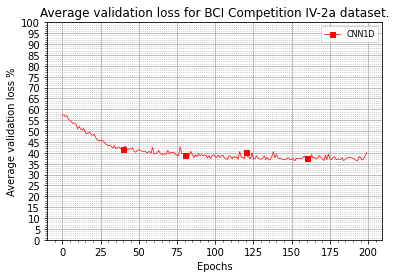

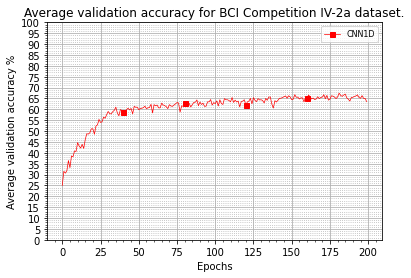

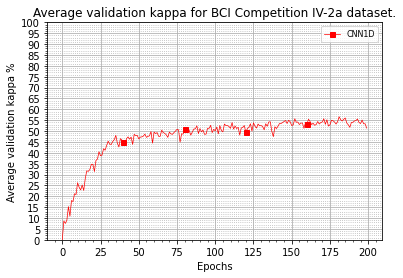

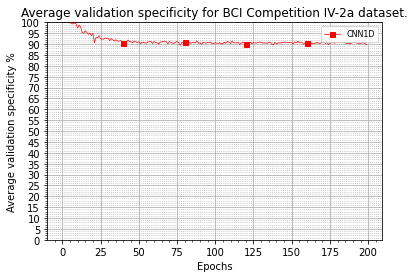

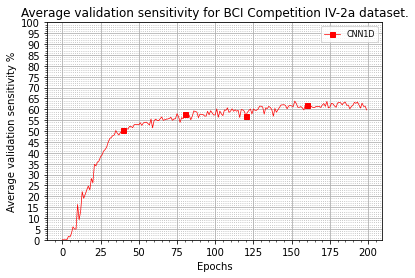

In [7]:
metrics = get_metrics()
print(f'Available metrics: {metrics}')
datasets=[dataset] # example: datasets=['physionet', 'ttk', 'bcicomptIV2a']
plot_results(datasets=datasets, metrics=metrics,ylim=[0,100],show=True,save=True)

# Get average values for the last epochs

In [ ]:
metrics = get_metrics()
print(f'Available metrics: {metrics}')
average_results(datasets=['physionet', 'ttk', 'bcicomptIV2a'], metrics=metrics,epochs=50,show=True, save=True)

# Get total validation time for each model from saved files

In [8]:
validation_time(datasets=['physionet', 'ttk', 'bcicomptIV2a'], show=True, save=True)

           bcicomptIV2a          
****************************
CNN1D             00:02:29


# Visualization (video array)

In [ ]:
# Generating 2D mapped data
pos_map = get_pos_map(dataset) # positions for 2D map conversion
data_x2D = make_into_2d(data_x,pos_map)

In [ ]:
# Generating video array for random samples
video_array(data_x2D, data_y, Class=1, Band=0, Rows=2, Cols=3)

samples = [1048 3201  121 2913 5155 3862]
